In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import mne
import os

# Import

In [139]:
df = pd.read_csv('eeg_metrics.csv')

df['condition'] = pd.Categorical(df['condition'], categories=['jhana', 'mindfulness', 'control'], ordered=False)
numeric_columns = df.select_dtypes(include=[np.number]).columns

df_button = df[df['button']!='all']
df_button['condition'] = df_button['jhana']
df_button_avg = df_button.groupby(['sub', 'day', 'condition'], as_index=False)[numeric_columns].mean()
condition_order = ['jhanaB', 'jhanaN', 'jhana1', 'jhana2', 'jhana3', 'jhana4']
df_button_avg['condition'] = pd.Categorical(df_button_avg['condition'], categories=condition_order, ordered=True)



df_control = df[df['button']=='all']
df_main = df_control[df_control['condition']!='control']
df_main['condition'] = pd.Categorical(df_main['condition'], categories=['jhana', 'mindfulness'], ordered=False)

df_main_avg = df_main.groupby(['sub', 'day', 'condition'], as_index=False)[numeric_columns].mean()
df_control_avg = df_control.groupby(['sub', 'condition'], as_index=False)[numeric_columns].mean()
df_control_avg = df_control_avg[~np.isnan(df_control_avg['n_epochs'])]


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1653752551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_button['condition'] = df_button['jhana']
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1653752551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['condition'] = pd.Categorical(df_main['condition'], categories=['jhana', 'mindfulness'], ordered=False)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1653752551.py:18: FutureWarning: T

## Run multi linear model

In [98]:
# general functions

def create_violin_plot(df, measure, group):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='condition', y=measure, data=df, inner='box', palette='muted')
    plt.title(f'Violin plot for {measure}')
    plt.savefig(f'figures/{group}_{measure}')
    plt.close()
    #plt.show()

def pointplot(df, measure, group):
    plt.figure(figsize=(10, 6))
    
    # Plot the individual data points (dots)
    sns.stripplot(x='condition', y=measure, data=df, jitter=True, color='gray', alpha=0.7)

    # Plot the means and confidence intervals (with a line connecting the means)
    sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')

    # Set the title and labels
    plt.title(f'{measure} by Condition with Mean and 95% CI', fontsize=14)
    plt.ylabel(measure)
    plt.xlabel('Condition')

    # Save the figure
    plt.savefig(f'figures/{group}_{measure}.png')
    plt.close()


# List of measures to compare
measures = [
    'lempel_ziv_norm',
    'permutation_entropy',
    'spectral_entropy',
    'sample_entropy',
    'hjorth_mobility',
    'hjorth_complexity',

    'nk_fsi',
    'nk_lle',
    'nk_sampen',
    'nk_pen',
    'nk_lzc',

    
    'delta',
    'theta',
    'alpha',
    'beta',
    'gamma'
]

In [97]:
# JHANA PEOPLE

def run_mixed_effects_model(df, measure):
    model = smf.mixedlm(f"{measure} ~ condition + day", 
                        df, 
                        groups=df["sub"],)  # Random intercept for 'sub'
                        #re_formula="~ ch_name")# + n_epochs + n_channels")  # Maybe I'll need to remove epochs and channels
    
    result = model.fit()
    print(result.summary())
    return result


# Run the model for each measure
results = {}
for measure in measures:
    print(f"Results for {measure}:")
    results[measure] = run_mixed_effects_model(df_main_avg, measure)
    pointplot(df_main_avg, measure, 'jhana')
    print("\n")


Results for lempel_ziv_norm:
               Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   lempel_ziv_norm
No. Observations:   80        Method:               REML           
No. Groups:         10        Scale:                0.0086         
Min. group size:    8         Log-Likelihood:       55.1462        
Max. group size:    8         Converged:            Yes            
Mean group size:    8.0                                            
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.691    0.036 19.406 0.000  0.621  0.760
condition[T.mindfulness] -0.085    0.021 -4.116 0.000 -0.126 -0.045
day[T.day2]              -0.013    0.029 -0.450 0.653 -0.071  0.044
day[T.day3]              -0.011    0.029 -0.363 0.717 -0.068  0.047
day[T.day4]              -0.078   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, c



Results for spectral_entropy:
               Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  spectral_entropy
No. Observations:    80       Method:              REML            
No. Groups:          10       Scale:               0.0046          
Min. group size:     8        Log-Likelihood:      78.8517         
Max. group size:     8        Converged:           Yes             
Mean group size:     8.0                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.733    0.026 28.003 0.000  0.682  0.785
condition[T.mindfulness] -0.067    0.015 -4.408 0.000 -0.096 -0.037
day[T.day2]              -0.008    0.021 -0.361 0.718 -0.050  0.034
day[T.day3]              -0.001    0.021 -0.036 0.971 -0.043  0.041
day[T.day4]              -0.053

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 



Results for hjorth_complexity:
              Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: hjorth_complexity
No. Observations:   80      Method:             REML             
No. Groups:         10      Scale:              0.9386           
Min. group size:    8       Log-Likelihood:     -117.4986        
Max. group size:    8       Converged:          Yes              
Mean group size:    8.0                                          
-----------------------------------------------------------------
                         Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept                2.713    0.302 8.987 0.000  2.121  3.304
condition[T.mindfulness] 0.603    0.217 2.783 0.005  0.178  1.028
day[T.day2]              0.272    0.306 0.889 0.374 -0.328  0.873
day[T.day3]              0.062    0.306 0.201 0.841 -0.539  0.662
day[T.day4]              0.879    0.306 2.868 0.004  0.27

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 



Results for nk_sampen:
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     nk_sampen
No. Observations:     80          Method:                 REML     
No. Groups:           10          Scale:                  0.0393   
Min. group size:      8           Log-Likelihood:         -2.5607  
Max. group size:      8           Converged:              Yes      
Mean group size:      8.0                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.547    0.081 19.179 0.000  1.389  1.705
condition[T.mindfulness] -0.186    0.044 -4.203 0.000 -0.273 -0.099
day[T.day2]              -0.044    0.063 -0.705 0.481 -0.167  0.079
day[T.day3]              -0.020    0.063 -0.320 0.749 -0.143  0.103
day[T.day4]              -0.178    0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, c

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     nk_lzc 
No. Observations:       80          Method:                 REML   
No. Groups:             10          Scale:                  0.0150 
Min. group size:        8           Log-Likelihood:         37.7467
Max. group size:        8           Converged:              Yes    
Mean group size:        8.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.642    0.038 16.913 0.000  0.568  0.717
condition[T.mindfulness] -0.055    0.027 -1.993 0.046 -0.108 -0.001
day[T.day2]              -0.060    0.039 -1.547 0.122 -0.136  0.016
day[T.day3]              -0.007    0.039 -0.180 0.857 -0.083  0.069
day[T.day4]              -0.066    0.039 -1.716 0.086 -0.142  0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 



Results for alpha:
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     alpha    
No. Observations:     80          Method:                 REML     
No. Groups:           10          Scale:                  2.9437   
Min. group size:      8           Log-Likelihood:         -176.9234
Max. group size:      8           Converged:              Yes      
Mean group size:      8.0                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 9.313    2.375  3.921 0.000  4.659 13.968
condition[T.mindfulness]  2.138    0.384  5.572 0.000  1.386  2.890
day[T.day2]              -1.222    0.543 -2.252 0.024 -2.285 -0.159
day[T.day3]              -0.767    0.543 -1.413 0.158 -1.830  0.297
day[T.day4]              -1.254    0.543 -

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/2950636239.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 

In [99]:
# CONTROL PEOPLE

def run_mixed_effects_model(df, measure):
    model = smf.mixedlm(f"{measure} ~ condition", 
                        df, 
                        groups=df["sub"],)  # Random intercept for 'sub'
                        #re_formula="~ ch_name")# + n_epochs + n_channels")  # Maybe I'll need to remove epochs and channels
    
    result = model.fit()
    print(result.summary())
    return result


results = {}
for measure in measures:
    print(f"Results for {measure}:")
    results[measure] = run_mixed_effects_model(df_control_avg, measure)
    pointplot(df_control_avg, measure, 'control')
    print("\n")


Results for lempel_ziv_norm:
               Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   lempel_ziv_norm
No. Observations:   33        Method:               REML           
No. Groups:         23        Scale:                0.0029         
Min. group size:    1         Log-Likelihood:       23.3378        
Max. group size:    2         Converged:            Yes            
Mean group size:    1.4                                            
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.669    0.036 18.721 0.000  0.599  0.739
condition[T.mindfulness] -0.088    0.024 -3.660 0.000 -0.135 -0.041
condition[T.control]     -0.057    0.048 -1.193 0.233 -0.150  0.036
Group Var                 0.010    0.133                           



Results for permutation_entropy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, c



Results for spectral_entropy:
               Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  spectral_entropy
No. Observations:    33       Method:              REML            
No. Groups:          23       Scale:               0.0018          
Min. group size:     1        Log-Likelihood:      33.6195         
Max. group size:     2        Converged:           Yes             
Mean group size:     1.4                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.721    0.025 29.396 0.000  0.673  0.769
condition[T.mindfulness] -0.069    0.019 -3.630 0.000 -0.106 -0.032
condition[T.control]     -0.041    0.033 -1.270 0.204 -0.105  0.023
Group Var                 0.004    0.077                           



Results for sample_entropy:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, c



Results for hjorth_mobility:
               Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   hjorth_mobility
No. Observations:   33        Method:               REML           
No. Groups:         23        Scale:                0.0055         
Min. group size:    1         Log-Likelihood:       12.8604        
Max. group size:    2         Converged:            Yes            
Mean group size:    1.4                                            
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.600    0.051 11.698 0.000  0.499  0.700
condition[T.mindfulness] -0.131    0.033 -3.951 0.000 -0.196 -0.066
condition[T.control]     -0.096    0.068 -1.415 0.157 -0.230  0.037
Group Var                 0.021    0.200                           



Results for hjorth_complexity

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     nk_fsi 
No. Observations:       33          Method:                 REML   
No. Groups:             23          Scale:                  0.0030 
Min. group size:        1           Log-Likelihood:         22.1067
Max. group size:        2           Converged:              Yes    
Mean group size:        1.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 2.123    0.038 56.401 0.000  2.049  2.196
condition[T.mindfulness] -0.101    0.024 -4.138 0.000 -0.149 -0.053
condition[T.control]     -0.068    0.050 -1.354 0.176 -0.166  0.030
Group Var                 0.011    0.139                           



Results for nk_lle:
              Mixed Linear Model Regress

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 



Results for nk_pen:
               Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      nk_pen 
No. Observations:      33           Method:                  REML   
No. Groups:            23           Scale:                   0.0000 
Min. group size:       1            Log-Likelihood:          81.0573
Max. group size:       2            Converged:               Yes    
Mean group size:       1.4                                          
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 0.976    0.007 146.204 0.000  0.963  0.989
condition[T.mindfulness] -0.009    0.002  -4.839 0.000 -0.013 -0.005
condition[T.control]     -0.013    0.009  -1.446 0.148 -0.030  0.005
Group Var                 0.000    0.059                            



Results for nk_lzc:
     

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.appl



Results for delta:
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     delta    
No. Observations:     33          Method:                 REML     
No. Groups:           23          Scale:                  23.3435  
Min. group size:      1           Log-Likelihood:         -102.1666
Max. group size:      2           Converged:              Yes      
Mean group size:      1.4                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                13.175    2.130  6.185 0.000  9.000 17.349
condition[T.mindfulness]  3.012    2.161  1.394 0.163 -1.223  7.247
condition[T.control]     -0.068    2.833 -0.024 0.981 -5.621  5.485
Group Var                22.027    5.134                           



Results for theta:
              Mixed 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 



Results for alpha:
              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     alpha   
No. Observations:     33          Method:                 REML    
No. Groups:           23          Scale:                  2.0658  
Min. group size:      1           Log-Likelihood:         -92.4422
Max. group size:      2           Converged:              Yes     
Mean group size:      1.4                                         
------------------------------------------------------------------
                         Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                 8.478    2.125 3.989 0.000  4.313 12.643
condition[T.mindfulness]  2.163    0.643 3.365 0.001  0.903  3.422
condition[T.control]      2.063    2.827 0.730 0.465 -3.477  7.604
Group Var                43.102   17.384                          



Results for beta:
               Mixed Linear Model R

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='co

In [128]:
# CONTROL PEOPLE

def run_mixed_effects_model(df, measure):
    model = smf.mixedlm(f"{measure} ~ condition", 
                        df, 
                        groups=df["sub"],)  # Random intercept for 'sub'
                        #re_formula="~ ch_name")# + n_epochs + n_channels")  # Maybe I'll need to remove epochs and channels
    
    result = model.fit()
    print(result.summary())
    return result


results = {}
for measure in measures:
    print(f"Results for {measure}:")
    results[measure] = run_mixed_effects_model(df_button_avg, measure)
    pointplot(df_button_avg, measure, 'button')
    print("\n")


Results for lempel_ziv_norm:
            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: lempel_ziv_norm
No. Observations:  163     Method:             REML           
No. Groups:        9       Scale:              0.0097         
Min. group size:   8       Log-Likelihood:     117.8811       
Max. group size:   23      Converged:          Yes            
Mean group size:   18.1                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.680    0.046 14.789 0.000  0.590  0.771
condition[T.jhanaN]  0.010    0.032  0.315 0.753 -0.052  0.072
condition[T.jhana1]  0.008    0.026  0.304 0.761 -0.042  0.058
condition[T.jhana2] -0.009    0.026 -0.365 0.715 -0.060  0.041
condition[T.jhana3] -0.016    0.027 -0.580 0.562 -0.068  0.037
condition[T.jhana4] -0.043    0.028 -1.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter spac

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: permutation_entropy
No. Observations: 163     Method:             REML               
No. Groups:       9       Scale:              0.0000             
Min. group size:  8       Log-Likelihood:     532.2194           
Max. group size:  23      Converged:          Yes                
Mean group size:  18.1                                           
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.979    0.006 162.430 0.000  0.967  0.991
condition[T.jhanaN]    0.001    0.002   0.616 0.538 -0.003  0.006
condition[T.jhana1]   -0.001    0.002  -0.800 0.424 -0.005  0.002
condition[T.jhana2]   -0.002    0.002  -0.985 0.325 -0.005  0.002
condition[T.jhana3]   -0.004    0.002  -2.117 0.034 -0.008 -0.000
condition[T.jhana4]   -0

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.appl



Results for sample_entropy:
            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: sample_entropy
No. Observations:   163     Method:             REML          
No. Groups:         9       Scale:              0.0419        
Min. group size:    8       Log-Likelihood:     2.3336        
Max. group size:    23      Converged:          Yes           
Mean group size:    18.1                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.528    0.102 14.982 0.000  1.328  1.727
condition[T.jhanaN]  0.022    0.066  0.336 0.737 -0.107  0.151
condition[T.jhana1]  0.004    0.053  0.084 0.933 -0.100  0.109
condition[T.jhana2] -0.029    0.054 -0.536 0.592 -0.134  0.076
condition[T.jhana3] -0.048    0.056 -0.871 0.384 -0.157  0.061
condition[T.jhana4] -0.097    0.059 -1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 

            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: hjorth_mobility
No. Observations:  163     Method:             REML           
No. Groups:        9       Scale:              0.0160         
Min. group size:   8       Log-Likelihood:     77.6758        
Max. group size:   23      Converged:          Yes            
Mean group size:   18.1                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.625    0.066  9.471 0.000  0.496  0.754
condition[T.jhanaN]  0.013    0.041  0.326 0.745 -0.066  0.093
condition[T.jhana1]  0.010    0.033  0.313 0.754 -0.054  0.075
condition[T.jhana2] -0.018    0.033 -0.536 0.592 -0.083  0.047
condition[T.jhana3] -0.025    0.034 -0.717 0.473 -0.092  0.043
condition[T.jhana4] -0.068    0.036 -1.881 0.060 -0.139  0.003
Group

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='co

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: hjorth_complexity
No. Observations: 163     Method:             REML             
No. Groups:       9       Scale:              1.0462           
Min. group size:  8       Log-Likelihood:     -246.6577        
Max. group size:  23      Converged:          Yes              
Mean group size:  18.1                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.885    0.356  8.116 0.000  2.189  3.582
condition[T.jhanaN]  -0.067    0.329 -0.204 0.839 -0.711  0.577
condition[T.jhana1]   0.023    0.265  0.087 0.930 -0.497  0.543
condition[T.jhana2]   0.152    0.268  0.569 0.569 -0.372  0.677
condition[T.jhana3]   0.308    0.277  1.112 0.266 -0.235  0.852
condition[T.jhana4]   0.394    0.292  1.346 0.178 -0.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')


            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    nk_fsi 
No. Observations:    163        Method:                REML   
No. Groups:          9          Scale:                 0.0179 
Min. group size:     8          Log-Likelihood:        71.2856
Max. group size:     23         Converged:             Yes    
Mean group size:     18.1                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            2.144    0.054 39.654 0.000  2.038  2.250
condition[T.jhanaN]  0.008    0.043  0.181 0.857 -0.077  0.092
condition[T.jhana1] -0.002    0.035 -0.052 0.959 -0.070  0.066
condition[T.jhana2] -0.025    0.035 -0.716 0.474 -0.094  0.043
condition[T.jhana3] -0.052    0.036 -1.423 0.155 -0.123  0.019
condition[T.jhana4] -0.068    0.038 -1.774 0.076 -0.143  0.007
Group

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   nk_lle   
No. Observations:    163       Method:               REML     
No. Groups:          9         Scale:                0.2392   
Min. group size:     8         Log-Likelihood:       -137.1630
Max. group size:     23        Converged:            Yes      
Mean group size:     18.1                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            6.987    0.335 20.852 0.000  6.330  7.644
condition[T.jhanaN] -0.141    0.157 -0.897 0.370 -0.450  0.167
condition[T.jhana1] -0.036    0.127 -0.285 0.776 -0.285  0.213
condition[T.jhana2]  0.040    0.128  0.309 0.757 -0.211  0.290
condition[T.jhana3]  0.105    0.133  0.793 0.428 -0.155  0.366
condition[T.jhana4]  0.224    0.140  1.596 0.110 -0.051  0.498
Group

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, c



Results for nk_lzc:
            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    nk_lzc 
No. Observations:    163        Method:                REML   
No. Groups:          9          Scale:                 0.0164 
Min. group size:     8          Log-Likelihood:        78.8327
Max. group size:     23         Converged:             Yes    
Mean group size:     18.1                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.675    0.049 13.863 0.000  0.580  0.771
condition[T.jhanaN] -0.012    0.041 -0.296 0.768 -0.093  0.068
condition[T.jhana1] -0.015    0.033 -0.455 0.649 -0.080  0.050
condition[T.jhana2] -0.047    0.033 -1.401 0.161 -0.112  0.019
condition[T.jhana3] -0.041    0.035 -1.189 0.235 -0.109  0.027
condition[T.jhana4] -0.080    0.037 -2.194 0.0

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')




Results for delta:
            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta    
No. Observations:    163       Method:               REML     
No. Groups:          9         Scale:                329.0162 
Min. group size:     8         Log-Likelihood:       -693.2746
Max. group size:     23        Converged:            Yes      
Mean group size:     18.1                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z   P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           12.624    4.357 2.897 0.004   4.084 21.164
condition[T.jhanaN]  1.002    5.817 0.172 0.863 -10.399 12.403
condition[T.jhana1]  2.547    4.699 0.542 0.588  -6.663 11.758
condition[T.jhana2]  4.649    4.737 0.982 0.326  -4.635 13.933
condition[T.jhana3]  6.117    4.901 1.248 0.212  -3.489 15.724
condition[T.jhana4]  1.788    5.161 0.346 0.729

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')




Results for theta:
            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   theta    
No. Observations:    163       Method:               REML     
No. Groups:          9         Scale:                2.5146   
Min. group size:     8         Log-Likelihood:       -318.8373
Max. group size:     23        Converged:            Yes      
Mean group size:     18.1                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            3.206    0.774  4.142 0.000  1.689  4.723
condition[T.jhanaN] -0.002    0.510 -0.003 0.997 -1.001  0.998
condition[T.jhana1]  0.366    0.411  0.890 0.374 -0.440  1.172
condition[T.jhana2]  0.556    0.415  1.340 0.180 -0.257  1.369
condition[T.jhana3]  0.588    0.431  1.365 0.172 -0.256  1.432
condition[T.jhana4]  0.386    0.454  0.850 0.39

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')




Results for alpha:
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   alpha    
No. Observations:   163       Method:               REML     
No. Groups:         9         Scale:                2.7591   
Min. group size:    8         Log-Likelihood:       -333.9849
Max. group size:    23        Converged:            Yes      
Mean group size:    18.1                                     
-------------------------------------------------------------
                    Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            7.374    2.043 3.610 0.000  3.371 11.378
condition[T.jhanaN]  0.057    0.535 0.107 0.915 -0.991  1.105
condition[T.jhana1]  0.192    0.431 0.446 0.656 -0.653  1.037
condition[T.jhana2]  0.187    0.435 0.431 0.667 -0.665  1.040
condition[T.jhana3]  0.030    0.451 0.066 0.947 -0.855  0.914
condition[T.jhana4]  0.004    0.476 0.009 0.993 -0.928  0.937

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat 

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  beta     
No. Observations:    163      Method:              REML     
No. Groups:          9        Scale:               0.4904   
Min. group size:     8        Log-Likelihood:      -190.6630
Max. group size:     23       Converged:           Yes      
Mean group size:     18.1                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.976    0.347 2.809 0.005  0.295  1.656
condition[T.jhanaN] 0.050    0.225 0.223 0.824 -0.391  0.491
condition[T.jhana1] 0.330    0.182 1.819 0.069 -0.026  0.687
condition[T.jhana2] 0.431    0.183 2.350 0.019  0.072  0.790
condition[T.jhana3] 0.370    0.190 1.948 0.051 -0.002  0.743
condition[T.jhana4] 0.133    0.200 0.665 0.506 -0.260  0.526
Group Var           0.919    0.693  

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='condition', y=measure, data=df, ci=95, capsize=0.1, join=True, color='blue')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/1025089284.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='co



Results for gamma:
           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  gamma    
No. Observations:    163      Method:              REML     
No. Groups:          9        Scale:               0.6909   
Min. group size:     8        Log-Likelihood:      -216.6883
Max. group size:     23       Converged:           Yes      
Mean group size:     18.1                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.411    0.375 1.097 0.273 -0.323  1.146
condition[T.jhanaN] 0.079    0.267 0.296 0.767 -0.445  0.603
condition[T.jhana1] 0.377    0.216 1.748 0.081 -0.046  0.800
condition[T.jhana2] 0.489    0.218 2.249 0.025  0.063  0.916
condition[T.jhana3] 0.358    0.226 1.586 0.113 -0.084  0.800
condition[T.jhana4] 0.062    0.238 0.261 0.794 -0.404  0.528
Group Var      

# Visualization in TopoMaps

In [150]:
# Import epochs to get layout information
epochs = mne.read_epochs('epochs/sub01-day1-jhana_epo.fif')
epochs.info['bads'] = []
layout = mne.pick_info(epochs.info, sel=mne.pick_types(epochs.info, eeg=True))
layout_channel_order = layout['ch_names']

# Function to plot topomaps for multiple measures
def plot_topomap_for_measures(df, measures):
    # mean centre the data
    for col in df.columns[8:]:
        overall_mean = df[col].mean()
        df[col] = df[col] - overall_mean  # Subtract the mean from the column

    conditions_list = df['condition'].unique().tolist()
    len_conditions = len(conditions_list)
    
    # Prepare a figure with subplots: one row per measure, and two columns for the conditions (Jhana, Mindfulness)
    fig, axes = plt.subplots(len(measures), len_conditions, figsize=(10, 4 * len(measures)))  # Adjust figure size dynamically

    # Loop through each measure
    for measure_idx, measure in enumerate(measures):
        grouped_data = df.groupby(['condition', 'ch_name'], as_index=False)[[measure]].mean()
        vmin = grouped_data[measure].min()  # Global minimum value
        vmax = grouped_data[measure].max()  # Global maximum value
        # Loop over each condition (Jhana, Mindfulness)
        for condition_idx, condition in enumerate(conditions_list):
            # Filter the dataframe for the specific condition
            condition_data = grouped_data[grouped_data['condition'] == condition]
            condition_data = condition_data.set_index('ch_name').reindex(layout_channel_order).reset_index()

            # Extract the measure values for all channels for the specific condition
            measure_values = condition_data[measure].values

            # Plot the topomap on the appropriate subplot
          #  ax = axes[measure_idx, condition_idx] if len(measures) > 1 else axes[condition_idx]  # Handle case for single measure
          #  mne.viz.plot_topomap(measure_values, layout, axes=ax, show=False, cmap='viridis')
          #  ax.set_title(f'{condition.capitalize()} ({measure})')

            # Plot the topomap on the appropriate subplot
            ax = axes[measure_idx, condition_idx] if len(measures) > 1 else axes[condition_idx]  # Handle case for single measure
            norm = Normalize(vmin=vmin, vmax=vmax)
            im, _ = mne.viz.plot_topomap(measure_values, layout, axes=ax, show=False, cmap='viridis', cnorm=norm)

            # Add the colorbar manually
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label(f'{measure.capitalize()}')

            # Set the title for the subplot
            ax.set_title(f'{condition.capitalize()} ({measure})')


    

    # Set the overall title for the figure
    #plt.suptitle('Topomaps for Measures', fontsize=16)
    plt.tight_layout()
    plt.show()

Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/resting state/epochs/sub01-day1-jhana_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2996.09 ms
        0 CTF compensation matrices available
Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/222996799.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['condition', 'ch_name'], as_index=False)[[measure]].mean()
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/222996799.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['condition', 'ch_name'], as_index=False)[[measure]].mean()
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/222996799.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version

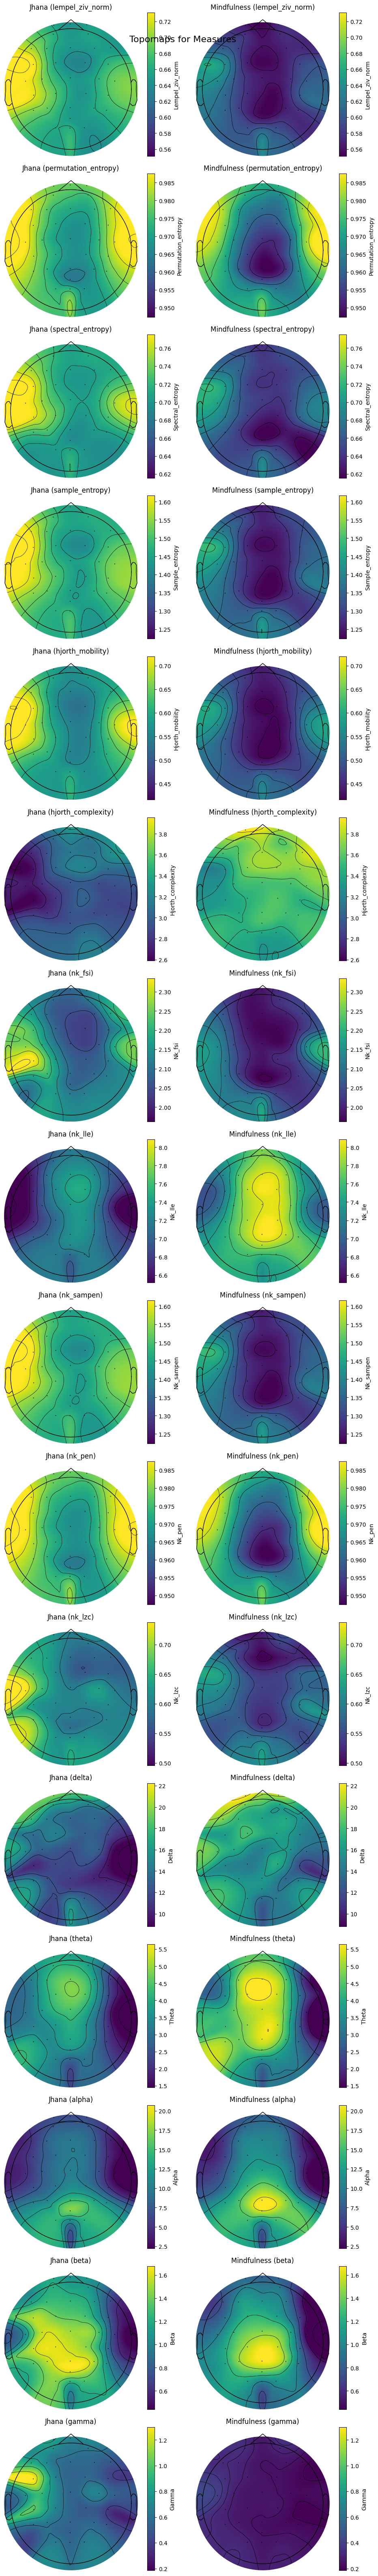

In [140]:
plot_topomap_for_measures(df_main, measures)

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/3807921957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] - overall_mean  # Subtract the mean from the column
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/3807921957.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['condition', 'ch_name'], as_index=False)[[measure]].mean()
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_56155/3807921957.py:19: FutureWarning: The default of observed=False is deprecated and will

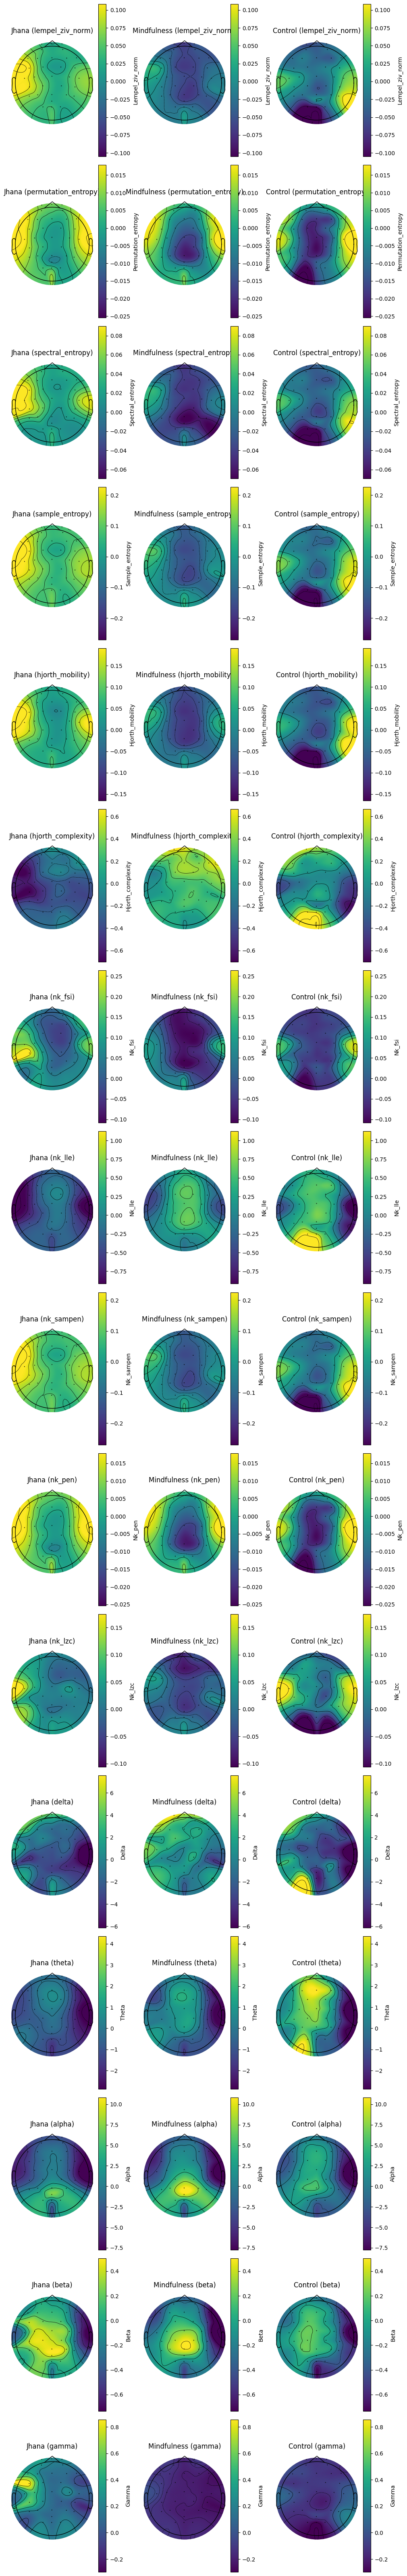

In [149]:
plot_topomap_for_measures(df_control, measures)

In [156]:
df_control['condition'].unique().tolist()

['jhana', 'mindfulness', 'control']